In [1]:
# create functions

import timeit
start = timeit.default_timer()

import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd

from IPython.display import Audio
from scipy.signal.windows import hamming




# Normalizing
def normalize(x):
    return (x-min(abs(x)))/(max(x)-min(abs(x)))


# Class

class Frame:
    
    # Thresholds init
    zcr_treshold = 0
    ste_treshold = 0


    def __init__(self, samples):

        self.frame_size = len(samples)
        self.samples = np.array(samples)
        self.classification = 0
        self.zcr = 0
        self.ste = 0
        self.classification_vector = []

        # Hamming window init for each frame
        self.hamm_window = hamming(self.frame_size)


    # Function to calculate Zero crossing rate
    def zero_crossing_rate(self):

        return sum(abs(np.diff(self.samples > 0))) / len(self.samples)
    
    # Function to calculate Short Time Energy
    def short_time_energy(self):
        temp = 0
        energy = 0
        for i, value in enumerate(self.samples):
            temp = pow(self.samples[i]*self.hamm_window[len(self.hamm_window) - 1 - i],2)
            energy += temp
        return energy / len(self.samples)
    
    
   # Function to calulate the parameters of the frame
    def calculate_frame_parameters(self):
        self.zcr = self.zero_crossing_rate()
        self.ste = self.short_time_energy()


    # Function to classify the frame as voiced/ unvoiced / DN
    def classify(self):

        self.calculate_frame_parameters()

        if self.zcr < Frame.zcr_treshold and self.ste > Frame.ste_treshold:
            self.classification = 1

        elif self.zcr > Frame.zcr_treshold and self.ste < Frame.ste_treshold:
            self.classification = 0

        else:
            self.classification = 2
            

        

    # decode to string event/ non-event / DN frame
    def decodeFrame(self):
        if(self.classification == 0):
            return 'non-event'
        elif self.classification == 1:
            return 'event'
        else:
            return 'DN'
    


    # Function to print the parameters
    def getParameters(self):
        print('zero crossing rate: {}'.format(self.zcr))
        print('short time energy: {}'.format(self.ste))
        print('classification: {}'.format(self.decodeFrame()))
        print('length in samples: {}'.format(len(self.samples)))
        

    # Function to plot the frame
    def plotFrame(self):
        plt.plot(self.samples)
        plt.grid()
        plt.show()
        
stop = timeit.default_timer()
execution_time = stop - start

print("Program Executed in "+str(execution_time)+"Seconds")

Program Executed in 1.507312Seconds


In [2]:
# import Data
start = timeit.default_timer()
import mat73
data = mat73.loadmat('signal.mat')
locals().update(data)

import numpy as np
signal = signal.transpose()
signal = signal.ravel()


# process further
y, sr = signal, len(signal)

# write the data with 14 bit depth
import numpy as np
y = np.float16(y)
y = y*pow(2,-2)

# setting the duration of single frame
f_d = 0.001
frame_size = int(f_d * sr)
n = int(len(y)/frame_size)

# setting min duration of single frame
f_d_min = 0.0002
frame_size_min = int(f_d_min * sr)

df = [[0]*frame_size]*n
temp = 0

# Read data
for i in range (0,n):
    df[i] = y[temp : frame_size + temp]
    temp += frame_size


# Function to set thresholds

def setThreshold(n_threshold, df):
    thres_zcr_tab = []
    thres_ste_tab = []
    for i in range(0,n_threshold):
        frame_set = Frame(df[i])
        frame_set.calculate_frame_parameters()
        thres_ste_tab.append(frame_set.ste)
        thres_zcr_tab.append(frame_set.zcr)


    Frame.ste_treshold = max(thres_ste_tab) *1e1
    Frame.zcr_treshold = min(thres_zcr_tab) 

# first x seconds is supposed to be noise
t_threshold = 0.002
n_threshold = int(t_threshold/f_d)

# Set thresholds
setThreshold(n_threshold,df)

# arrays
frames_to_process = []
frames_processed = []

# compute all frames
for i, values in enumerate(df):
    if len(frames_to_process) == 0:
        frame0 = Frame(df[i])
        frames_to_process.append(frame0)

        # untill the array is empty
        while len(frames_to_process) != 0:
            
            
            frame0 = frames_to_process[0]

            # classify the frame
            frame0.classify()
            
            # If the frame is too short, it i classified as unvoiced
            if frame0.frame_size < frame_size_min:
                frame0.classification = 0


            
            # If DN
            if frame0.classification == 2:
                
                frame1 = Frame(frame0.samples[0:int(frame0.frame_size/2)])

                frame2 = Frame(frame0.samples[int(frame0.frame_size/2):])
                
                frames_to_process.remove(frame0)

                frames_to_process.insert(0,frame1)
                frames_to_process.insert(1,frame2)
            else:
                frames_processed.append(frame0)
                frames_to_process.remove(frame0)
        
        
print('number of frames processed: {}'.format(len(frames_processed)))

# to the plots
vector_ste_thres = []
vector_zcr_thres = []
vector_zcr=[]
vector_ste=[]
vector_classification = []
for value in frames_processed:
    
    #ZCR to plots
    temp = [value.zcr]*value.frame_size
    vector_zcr += temp

    #STE to plots
    temp = [value.ste]*value.frame_size
    vector_ste +=temp

    #classification
    temp = [value.classification]*value.frame_size
    vector_classification += temp

    vector_ste_thres += [Frame.ste_treshold]*value.frame_size
    vector_zcr_thres += [Frame.zcr_treshold]*value.frame_size


stop = timeit.default_timer()
execution_time = stop - start

print("Program Executed in "+str(execution_time)+"Seconds")

number of frames processed: 1909
Program Executed in 1.6998603999999915Seconds


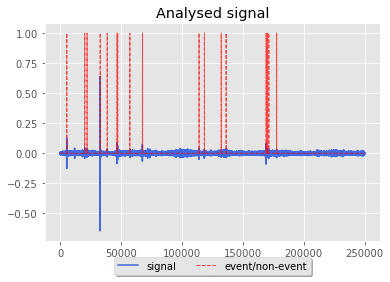

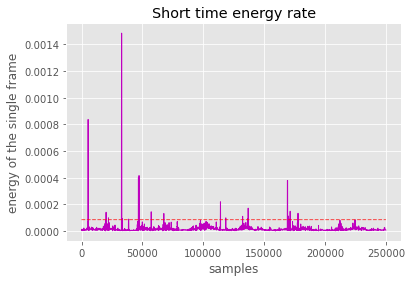

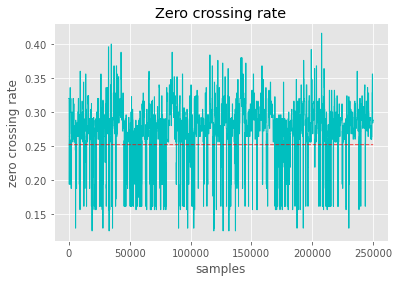

Program Executed in 0.5810191999999859Seconds


In [3]:
# plot
start = timeit.default_timer()

#Plots
plt.style.use('ggplot')
fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()
fig3, ax3 = plt.subplots()

ax1.plot(y,color='royalblue', label = 'signal')
ax1.plot(vector_classification,color = 'r', linestyle = '--', label = 'event/non-event', linewidth = 1, alpha = 0.7)
ax1.set_title('Analysed signal')
ax1.set_xlabel('samples')
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), shadow=True, ncol=2)

ax2.plot(vector_ste, color = 'm', linestyle = '-', label = 'Short time energy rate', linewidth = 1)
ax2.set_xlabel('samples')
ax2.set_ylabel('energy of the single frame')
ax2.set_title('Short time energy rate')
ax2.plot(vector_ste_thres, 'r--', label = 'ste threshold', linewidth = 1, alpha = 0.7)

ax3.plot(vector_zcr, color = 'c',linestyle = '-', label = 'Zero crossing rate', linewidth =1)
ax3.set_xlabel('samples')
ax3.set_ylabel('zero crossing rate')
ax3.set_title('Zero crossing rate')
ax3.plot(vector_zcr_thres, 'r--', label = 'zcr threshold', linewidth = 1, alpha = 0.7)

plt.show()

stop = timeit.default_timer()
execution_time = stop - start

print("Program Executed in "+str(execution_time)+"Seconds")